In [1]:
import numpy as np
import matplotlib.pyplot as plt

from manage_measures import PkMeasure, BkMeasure
from power_spectrum_modelling import PowerSpectrumModel
from bispectrum_modelling import BispectrumModel

root_directory = "../"

In [2]:
# Here we define the dataset we want to model
# We must set specification 
#
# 1) Halpha model: it can be 1 or 3
#
# 2) Snapshot number: we have 4 possible choices
#    00045 : z = 0.9 
#    00037 : z = 1.2
#    00030 : z = 1.5
#    00026 : z = 0.9

In [3]:
model = 1

snapshot = "00026"

In [4]:
# Now let's set probe-specific quantities

In [5]:
# Power spectrum
# 1) Binning: 
#    1 : 1 time the fundamental frequency
#    2 : 1.5 time the fundamental frequency
#    3 : 2 time the fundamental frequency
# 2) kmin: minimum value for the the wavenumber module
# 3) kmax: maximum value for the the wavenumber module

In [6]:
pk_binning = 1
pk_kmin = 0
pk_kmax = 0.25

In [7]:
#Read the full power spectrum

pk_measure = PkMeasure(model, snapshot, pk_binning, root_directory)

In [8]:
#Fit-ready quantities

pk, err_pk, pk_ww = pk_measure(pk_kmin, pk_kmax)
keff = pk_measure.keff[pk_ww]

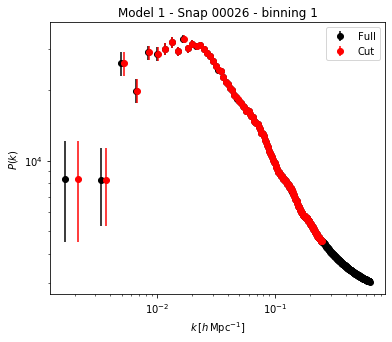

In [9]:
#Plot of the power spectrum

figure, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.set_xscale("log")
ax.set_yscale("log")
ax.errorbar(pk_measure.kk, pk_measure.pk, yerr=pk_measure.delta_pk, fmt="o", color="k", label="Full")
ax.errorbar(pk_measure.keff[pk_ww], pk, yerr=err_pk, fmt="o", color="r", label="Cut")

ax.set_xlabel(r"$ k \, [h \, \mathrm{Mpc}^{-1}]$")
ax.set_ylabel(r"$ P(k) $")
ax.set_title("Model %d - Snap %s - binning %d"%(model, snapshot, pk_binning))
ax.legend(loc="best")
plt.show()

In [10]:
#Fit

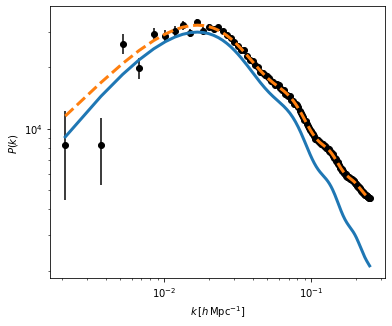

In [11]:
#Model by MDB
b1 = 2.4583
b2 = 0.7399
bG2 = -0.7458
bGamma3 = 1.5436
c0 = 1.0144
alpha = 0.1032

model_pk = PowerSpectrumModel(snapshot)
pk_model = model_pk(keff, b1, b2, bG2, bGamma3, c0)
pk_model_SN = pk_model+(1+alpha)*pk_measure.inverse_density

figure, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.set_xscale("log")
ax.set_yscale("log")

ax.errorbar(pk_measure.keff[pk_ww], pk, yerr=err_pk, fmt="o", color="k", label="Cut", zorder=-100)

ax.plot(keff, pk_model,'-', lw=3, label="Model")
ax.plot(keff, pk_model_SN,'--', lw=3, label="Model")
ax.set_xlabel(r"$ k \, [h \, \mathrm{Mpc}^{-1}]$")
ax.set_ylabel(r"$ P(k) $")
plt.show()

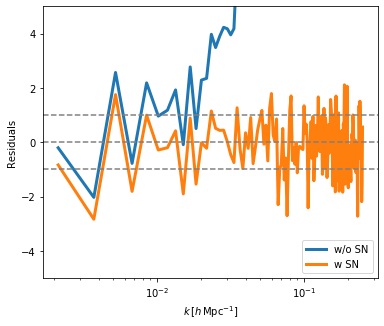

In [12]:
figure, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.set_xscale("log")
ax.set_yscale("linear")
ax.set_ylim([-5, 5])

ax.plot(keff, (pk-pk_model)/err_pk,'-', lw=3, label="w/o SN")
ax.plot(keff, (pk-pk_model_SN)/err_pk,'-', lw=3, label="w SN")

ax.axhline(0, ls="--", color="0.5")
ax.axhline(1, ls="--", color="0.5")
ax.axhline(-1, ls="--", color="0.5")

ax.legend(loc="lower right")
ax.set_xlabel(r"$ k \, [h \, \mathrm{Mpc}^{-1}]$")
ax.set_ylabel("Residuals")

plt.show()

In [13]:
#Run chains
import emcee

def lnlik(theta, kk, pk, err_pk, model, inv_density):
    mod = model(keff, *theta[0:-1])+(1+theta[-1])*inv_density
    return -0.5 * np.sum( (pk-mod)**2 / err_pk**2)

def lnprior(theta):
    b1, b2, bG2, bGamma3, c0, alpha = theta
    if (b1>0.25) & (b1<4) & (b2>-10) & (b2<10) & (bG2>-4) & (bG2<4) &\
       (bGamma3 > -8) & (bGamma3 < 8) & (c0>-500) & (c0<500) & (alpha>-1) & (alpha<2):
        return 0
    return -np.inf

def lnprob(theta, kk, pk, err_pk, model, inv_density):
    lnpr = lnprior(theta)
    if not np.isfinite(lnpr):
        return -np.inf
    return lnlik(theta, kk, pk, err_pk, model, inv_density) + lnpr

In [14]:
ndim = 6
nwalkers = 100
chain_size = 10000
pos = [b1, b2, bG2, bGamma3, c0, 0.8592]
pos = pos + 1e-4 * np.random.randn(nwalkers, ndim)

arguments = (keff, pk, err_pk, model_pk, pk_measure.inverse_density)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=arguments)
sampler.run_mcmc(pos, chain_size, progress=True);
chain = sampler.get_chain(discard=0, thin=1, flat=True)

  0%|          | 35/10000 [00:01<11:03, 15.02it/s]Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-13-a0c1bb2e5f00>", line 19, in lnprob
    return lnlik(theta, kk, pk, err_pk, model, inv_density) + lnpr
  File "<ipython-input-13-a0c1bb2e5f00>", line 5, in lnlik
    mod = model_pk(keff, *theta[0:-1])+(1+theta[-1])*inv_density
  File "/Users/alfonso/Work/NonLinearModelling/non-linear-modelling-challenge/power_spectrum_modelling.py", line 52, in __call__
    bG2**2 * self.iPbG2bG2(k) -\
  File "/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py", line 915, in __call__
    self._ensure_c_contiguous()
  File "/opt/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py", line 786, in _ensure_c_contiguous
    if not self.c.flags.c_contiguous:
KeyboardInterrupt
  0%|          | 37/10000 [00:01<08:30, 19.5

emcee: Exception while calling your likelihood function:
  params: [ 2.39731343  0.67685456 -0.91316807  1.42443868  1.06695949  0.76666122]
  args: (array([0.00212123, 0.00370808, 0.00520966, 0.00674957, 0.0084733 ,
       0.01017598, 0.01175478, 0.01333943, 0.01505536, 0.01677736,
       0.01838621, 0.01999505, 0.02168325, 0.02336039, 0.02496087,
       0.02660317, 0.02831053, 0.03000721, 0.03164256, 0.03327522,
       0.03496004, 0.03662863, 0.0382671 , 0.03990831, 0.0415801 ,
       0.04326499, 0.04492738, 0.04658763, 0.0482539 , 0.04990756,
       0.05156297, 0.05321227, 0.05486647, 0.05654465, 0.05820977,
       0.05986584, 0.06153396, 0.06319814, 0.06484701, 0.06650094,
       0.06817642, 0.06984663, 0.07150519, 0.07316438, 0.07483325,
       0.0764943 , 0.07813548, 0.0797903 , 0.08146509, 0.08314175,
       0.08480055, 0.08645835, 0.08812793, 0.08978953, 0.09143887,
       0.09309009, 0.09476269, 0.09643163, 0.09808566, 0.09974969,
       0.10141761, 0.1030823 , 0.10472929, 0.1

KeyboardInterrupt: 

In [ ]:
from chainconsumer import ChainConsumer

names = [r"$b_1$", r"$b_2$", r"$b_{G2}$", r"$b_{\Gamma_3}$", r"$c_0$", r"$\alpha_P$"]

cc = ChainConsumer()
cc.add_chain(chain, parameters=names)
fig = cc.plotter.plot_walks(truth = [b1, b2, bG2, bGamma3, c0, 0.8592])

In [ ]:
cc = ChainConsumer()
cc.add_chain(chain[100000:], parameters=names)
fig = cc.plotter.plot(truth = [b1, b2, bG2, bGamma3, c0, 0.8592])

In [15]:
# Bispectrum
# 1) Binning: 
#    1 : 1 time the fundamental frequency
#    2 : 1.5 time the fundamental frequency
#    3 : 2 time the fundamental frequency
# 2) kmin: minimum value for the the wavenumber module
# 3) kmax: maximum value for the the wavenumber module

In [16]:
bk_binning = 3
bk_kmin = 0
bk_kmax = 0.08

In [17]:
#Read the full power spectrum

bk_measure = BkMeasure(model, snapshot, bk_binning, root_directory)

In [18]:
# Fit-ready bispectrum
# Here user can choose different combination of triangles.
# One must specify a triangle condition using an ad-hoc function
# as follows

In [49]:
# k12 <= k13 <= k23
# k12 <= kmax
# k23 >= kmin

def triangle_condition(k12, k13, k23):
    if (k12<=bk_kmax):
        return True
    return False

In [50]:
bk, err_bk, bk_ww = bk_measure(triangle_condition)


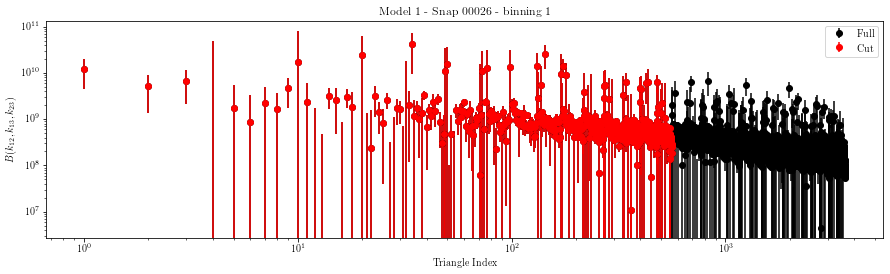

In [51]:
#Plot of the power spectrum

figure, ax = plt.subplots(1, 1, figsize=(15, 4))

ax.set_xscale("log")
ax.set_yscale("log")
triangle_index = np.arange(len(bk_measure.bk))

ax.errorbar(triangle_index, bk_measure.bk, yerr=bk_measure.delta_bk, fmt="o", color="k", label="Full")
ax.errorbar(triangle_index[bk_ww], bk, yerr=err_bk, fmt="o", color="r", label="Cut")

ax.set_xlabel(r"Triangle Index")
ax.set_ylabel(r"$ B(k_{12}, k_{13}, k_{23}) $")
ax.set_title("Model %d - Snap %s - binning %d"%(model, snapshot, pk_binning))
ax.legend(loc="best")

plt.show()

In [52]:
# Fit


In [53]:
model_bk = BispectrumModel(snapshot, bk_binning, "_no_pi")
model_bk_pi = BispectrumModel(snapshot, bk_binning)

MassimoG/Data/flagship_modelling/bispectrum_tree_IR_s3_c2_z1p8_MassimoG_no_pi.dat
MassimoG/Data/flagship_modelling/bispectrum_tree_IR_s3_c2_z1p8_MassimoG.dat


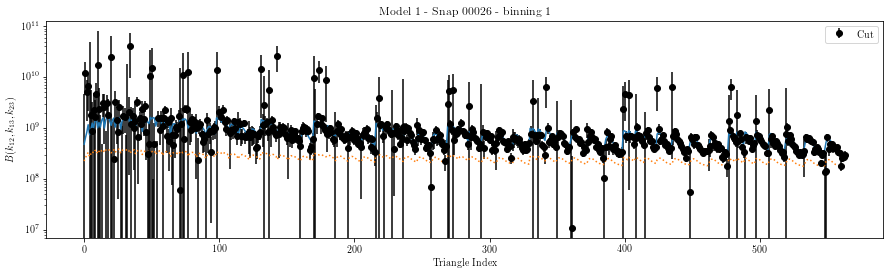

In [54]:
#Plot of the power spectrum

figure, ax = plt.subplots(1, 1, figsize=(15, 4))

bk_model = model_bk(b1, b2, bG2, 0,0)
bk_model2 = model_bk(b1, b2, bG2, 0.8,0.8)
bk_model_pi = model_bk_pi(b1, b2, bG2, 0.8,0.8)

ax.set_xscale("linear")
ax.set_yscale("log")
triangle_index = np.arange(len(bk_measure.bk))

ax.errorbar(triangle_index[bk_ww], bk, yerr=err_bk, fmt="o", color="k", label="Cut")
ax.plot(triangle_index[bk_ww], bk_model[bk_ww])
ax.plot(triangle_index[bk_ww], bk_model_pi[bk_ww], ':')

ax.set_xlabel(r"Triangle Index")
ax.set_ylabel(r"$ B(k_{12}, k_{13}, k_{23}) $")
ax.set_title("Model %d - Snap %s - binning %d"%(model, snapshot, pk_binning))
ax.legend(loc="best")

plt.show()

In [55]:
#Run chains

#Run chains
import emcee

def lnlik(theta, triangles, bk, err_bk, model):
    mod = model(*theta)[triangles]
    return -0.5 * np.sum( (bk-mod)**2 / err_bk**2)

def lnprior(theta):
    b1, b2, bG2, alpha_1, alpha_2 = theta
    if (b1>0.25) & (b1<4) & (b2>-10) & (b2<10) & (bG2>-4) & (bG2<4) &\
       (alpha_1>-1) & (alpha_1<1) & (alpha_2>-1) & (alpha_2<1):
        return 0
    return -np.inf

def lnprob(theta, triangles, bk, err_bk, model):
    lnpr = lnprior(theta)
    if not np.isfinite(lnpr):
        return -np.inf
    return lnlik(theta, triangles, bk, err_bk, model) + lnpr

In [56]:
ndim = 5
nwalkers = 100
chain_size = 10000
pos = [b1, b2, bG2, 0, 0]
pos = pos + 1e-4 * np.random.randn(nwalkers, ndim)

arguments = (bk_ww, bk, err_bk, model_bk)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=arguments)
sampler.run_mcmc(pos, chain_size, progress=True);
chain = sampler.get_chain(discard=0, thin=1, flat=True)

100%|██████████| 10000/10000 [02:23<00:00, 69.79it/s]


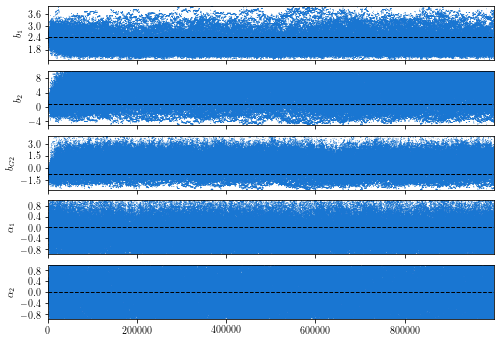

In [34]:
from chainconsumer import ChainConsumer

names = [r"$b_1$", r"$b_2$", r"$b_{G2}$", r"$\alpha_1$", r"$\alpha_2$"]

cc = ChainConsumer()
cc.add_chain(chain, parameters=names)
fig = cc.plotter.plot_walks(truth = [b1, b2, bG2, 0, 0])

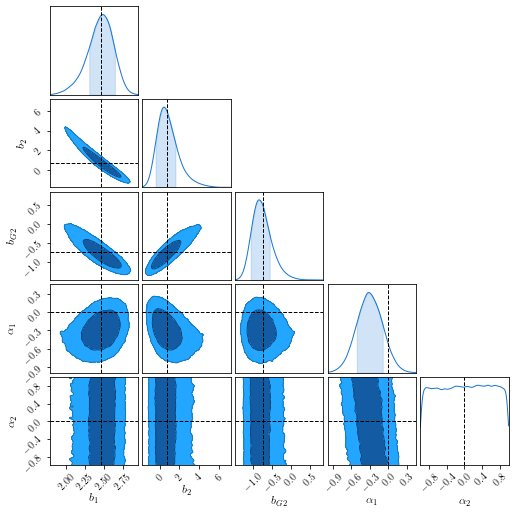

In [57]:
cc = ChainConsumer()
cc.add_chain(chain[100000:], parameters=names)
fig = cc.plotter.plot(truth = [b1, b2, bG2, 0, 0])